# Mixed GPs

BoTorch features a MixedSingleTaskGP model which is ideal for modelling the action-value (Q) function. For Q-learning we assume the set of actions $\mathcal{A}$ is discrete, while $\mathcal{S}$ may be continuous. Since the input to the GP is a point $z \in \mathcal{S} \times \mathcal{A}$ it is useful to take into account that the action set is discrete. For example, the MixedSingleTaskGP uses a custom kernel that combines a CategoricalKernel (based on Hamming distances) and a regular kernel of the form:
$$
k((x_1, c_1), (x_2, c_2)) = k_{cont1}(x_1, x_2) + k_{cat1}(c_1, c_2) + k_{cont2}(x_1, x_2) \cdot k_{cat2}(c_1,c-2)
$$

In [16]:
from botorch.models.transforms import Standardize
from botorch import fit_gpytorch_mll
from gpytorch import ExactMarginalLogLikelihood
import torch
from botorch.models import MixedSingleTaskGP
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples

# Define your data
X_continuous = torch.rand(10, 2, dtype=torch.double)  # Example continuous features
X_discrete = torch.randint(0, 2, (10, 1))  # Example discrete features
y = torch.randn(10, 1, dtype=torch.double)  # Example function values

# Normalize continuous features
X_continuous_norm = normalize(X_continuous, bounds=torch.tensor([[0, 0], [1, 1]]))

# Combine continuous and discrete features
X_mixed = torch.cat([X_continuous_norm, X_discrete.float()], dim=-1)

print(X_mixed)

# Define which dimensions are categorical
cat_dims = [2]  # Assuming the discrete feature is the third column (indexing starts from 0)

# Initialize the model
model = MixedSingleTaskGP(X_mixed, y, cat_dims=cat_dims,
                          outcome_transform=Standardize(m=1))

mll = ExactMarginalLogLikelihood(model.likelihood, model)

fit_gpytorch_mll(mll)

# Perform predictions
X_test_continuous = torch.rand(5, 2)  # Example test continuous features
X_test_discrete = torch.randint(0, 2, (5, 1))  # Example test discrete features
X_test_continuous_norm = normalize(X_test_continuous, bounds=torch.tensor([[0, 0], [1, 1]]))
X_test_mixed = torch.cat([X_test_continuous_norm, X_test_discrete.float()], dim=-1)

# Make predictions
with torch.no_grad():
    posterior = model.posterior(X_test_mixed)
    posterior_samples = posterior.rsample()

# You can then use these posterior samples for various purposes, e.g., optimization, decision making, etc.
print(posterior_samples)

tensor([[0.3749, 0.8452, 1.0000],
        [0.6278, 0.3880, 0.0000],
        [0.6491, 0.8290, 1.0000],
        [0.3658, 0.9635, 1.0000],
        [0.1208, 0.4997, 0.0000],
        [0.1256, 0.7649, 0.0000],
        [0.2193, 0.9901, 0.0000],
        [0.2026, 0.1566, 0.0000],
        [0.1372, 0.2535, 1.0000],
        [0.2437, 0.5655, 1.0000]], dtype=torch.float64)
tensor([[[-1.6223],
         [ 0.3104],
         [-0.2363],
         [-1.3751],
         [-0.4650]]], dtype=torch.float64)


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract the discrete actions and the corresponding posterior samples
X_test_discrete_np = X_test_discrete.numpy().flatten()
posterior_samples_np = posterior_samples.numpy()


/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1986: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


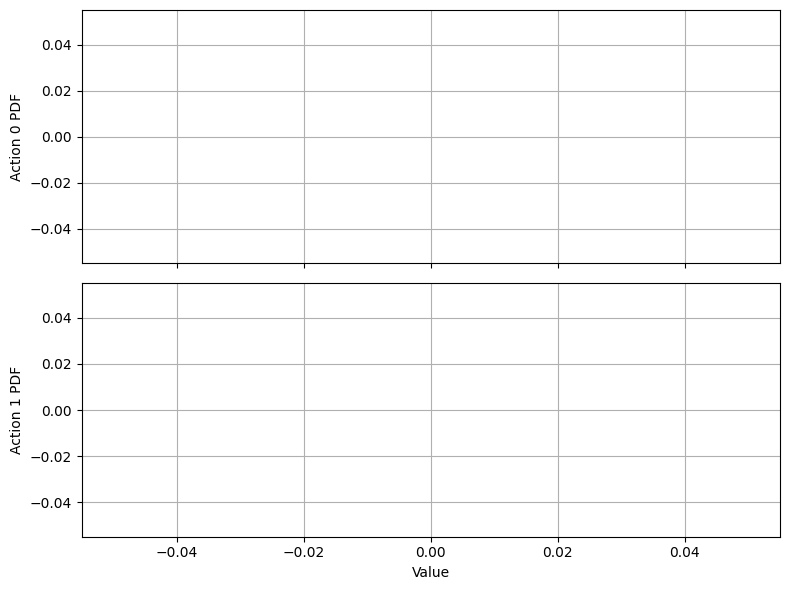

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def visualize_gaussians_for_actions(posterior_samples, action_size):
    """
    Visualize the Gaussian distributions for each action.
    :param posterior_samples: Posterior samples of the Q-function GP model.
    :param action_size: The number of possible actions.
    """
    fig, axs = plt.subplots(action_size, 1, figsize=(8, 6), sharex=True)

    for i in range(action_size):
        ax = axs[i]
        action_samples = posterior_samples[:, i]

        # Compute the mean and standard deviation of the samples
        mean = np.mean(action_samples)
        std = np.std(action_samples)

        # Plot the PDF of the Gaussian distribution
        x_values = np.linspace(mean - 3*std, mean + 3*std, 100)
        pdf = norm.pdf(x_values, mean, std)
        ax.plot(x_values, pdf, label=f'Action {i}')

        ax.set_ylabel(f'Action {i} PDF')
        ax.grid(True)

    plt.xlabel('Value')
    plt.tight_layout()
    plt.show()

# Example usage
visualize_gaussians_for_actions(posterior_samples_np, action_size=2)  # Adjust action_size as needed
